In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

In [37]:
# Load
df = pd.read_csv("GP3_Data.csv")

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create "post" variable (policy starts Mar 1)
df["post"] = (df["Date"] >= "2023-03-01").astype(int)

# Region dummies
df_dummy = pd.get_dummies(df["Region"], prefix="R", drop_first=False)
df = pd.concat([df, df_dummy], axis=1)

# Create Unit Discount Applied (Region 3 only)
df["Unit Discount Applied"] = ((df["Discount Applied"] == 1) & (df["Region"] == 3)).astype(int)

# Create Delivery Discount Applied (Region 4 only)
df["Delivery Discount Applied"] = ((df["Discount Applied"] == 1) & (df["Region"] == 4)).astype(int)

Diagnostic codes

In [17]:
# Check if unit price discount implemented since March
df.query("Region == 3").groupby("post")["Unit Price"].mean()

post
0    16.0
1    15.2
Name: Unit Price, dtype: float64

In [18]:
# Check if delivery fee discount applied since March
df.query("Region == 4").groupby("post")["Delivery Fees"].mean()

post
0    7.500
1    7.125
Name: Delivery Fees, dtype: float64

In [19]:
# Check if Discount Applied matches region rules
df.groupby(["Region", "post"])["Discount Applied"].mean()

Region  post
1       0       0.0
        1       0.0
2       0       0.0
        1       0.0
3       0       0.0
        1       1.0
4       0       0.0
        1       1.0
Name: Discount Applied, dtype: float64

# Descriptive Statistics

In [21]:
df.describe()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,post
count,480,480.0000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2023-03-01 12:00:00,2.5000,15.898333,14.041667,7.750000,3.827344,0.254167,0.508333
min,2023-01-01 00:00:00,1.0000,15.200000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,2023-01-30 18:00:00,1.7500,16.000000,10.000000,4.250000,2.125000,0.000000,0.000000
50%,2023-03-01 12:00:00,2.5000,16.000000,15.000000,7.000000,3.500000,0.000000,1.000000
75%,2023-03-31 06:00:00,3.2500,16.000000,18.000000,10.500000,5.156250,1.000000,1.000000
max,2023-04-30 00:00:00,4.0000,16.000000,24.000000,15.000000,7.500000,1.000000,1.000000
std,NaN,1.1192,0.266731,5.472491,4.872058,2.367201,0.435846,0.500452


In [20]:
# Summary statistics by region
summary_region = df.groupby("Region").agg({
    "Unit Price": "mean",
    "Quantity Ordered": ["mean", "std"],
    "Delivery Fees": "mean",
    "Discount Applied": "mean"
})
print(summary_region)

       Unit Price Quantity Ordered           Delivery Fees Discount Applied
             mean             mean       std          mean             mean
Region                                                                     
1       16.000000        19.458333  1.795867      1.000000         0.000000
2       16.000000        15.850000  1.912585      2.500000         0.000000
3       15.593333        12.550000  4.713382      4.500000         0.508333
4       16.000000         8.308333  4.813838      7.309375         0.508333


In [22]:
# Price before/after Mar 1 by region
price_change = df.groupby(["Region","post"])["Unit Price"].mean()
print(price_change)

# Quantity before/after Mar 1 by region
qty_change = df.groupby(["Region","post"])["Quantity Ordered"].mean()
print(qty_change)

Region  post
1       0       16.0
        1       16.0
2       0       16.0
        1       16.0
3       0       16.0
        1       15.2
4       0       16.0
        1       16.0
Name: Unit Price, dtype: float64
Region  post
1       0       19.762712
        1       19.163934
2       0       16.101695
        1       15.606557
3       0        9.406780
        1       15.590164
4       0        6.644068
        1        9.918033
Name: Quantity Ordered, dtype: float64


In [25]:
daily_demand = df.groupby("Date")["Quantity Ordered"].sum()
print(daily_demand.head())

Date
2023-01-01    50
2023-01-02    50
2023-01-03    64
2023-01-04    54
2023-01-05    62
Name: Quantity Ordered, dtype: int64


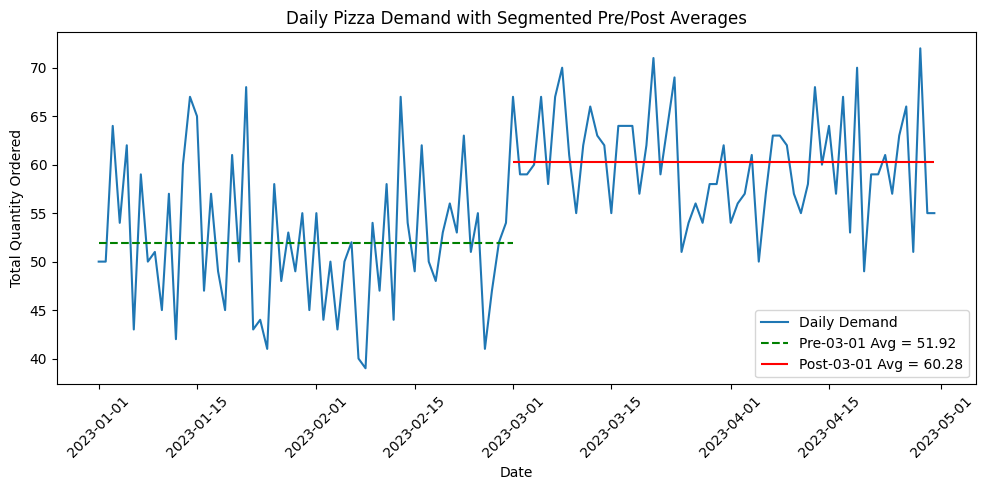

In [36]:
# Daily demand trend
# Define pre / post periods relative to 2023-03-01
# Daily total demand across all regions
daily = df.groupby("Date")["Quantity Ordered"].sum()

# Define cutoff
cutoff = pd.to_datetime("2023-03-01")

# Pre and post averages
pre_avg = daily[daily.index < cutoff].mean()
post_avg = daily[daily.index >= cutoff].mean()

# === Line chart with segmented average lines ===
plt.figure(figsize=(10, 5))

# Main daily demand line
plt.plot(daily.index, daily.values, label="Daily Demand")

# Pre-policy average line: from min date to cutoff
plt.hlines(pre_avg,
           xmin=daily.index.min(),
           xmax=cutoff,
           linestyles="--",
           color = "green",
           label=f"Pre-03-01 Avg = {pre_avg:.2f}")

# Post-policy average line: from cutoff to max date
plt.hlines(post_avg,
           xmin=cutoff,
           xmax=daily.index.max(),
           color = "red",
           linestyles="-",
           label=f"Post-03-01 Avg = {post_avg:.2f}")

plt.title("Daily Pizza Demand with Segmented Pre/Post Averages")
plt.xlabel("Date")
plt.ylabel("Total Quantity Ordered")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

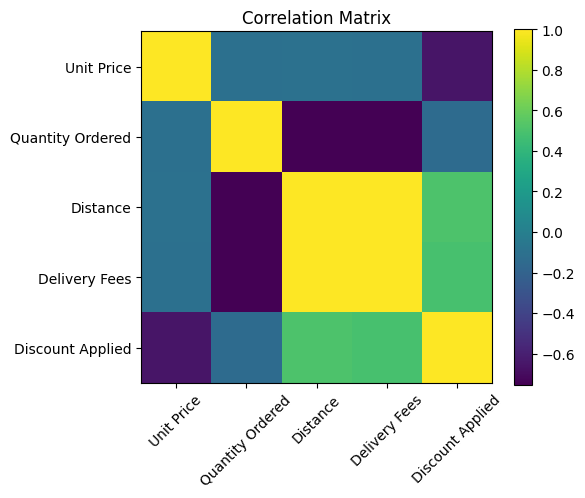

In [35]:
# Correlation Matrix
corr = df[["Unit Price",
           "Quantity Ordered",
           "Distance",
           "Delivery Fees",
           "Delivery Discount Applied",
           "Unit Discount Applied"]].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation="nearest")  # default colormap
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()